In [1]:
import numpy as np # arrays
import matplotlib.pyplot as plt # plots
plt.rcParams.update({'font.size': 10})
import cvxpy as cp
import sklearn

import sys
sys.path.append('D:/Work/dev/insitu_sim_python/insitu')
import lcurve_functions as lc

from controlsair import AlgControls, AirProperties, load_cfg, sph2cart
from sources import Source
from receivers import Receiver
from field_free import FreeField
from decompositionclass import Decomposition

%matplotlib notebook

# Teoria

Consideremos o campo sonoro em estado estacionário produzido por uma série de fontes de tom puro, com frequência $\omega$, numa sala qualquer. Por campo em estado estacionário referimo-nos a trasformada de Fourier de um fenômeno temporal:

\begin{equation}
p(t) \xrightarrow{\mathscr{F}} \tilde{p}(\text{j} \omega)
\end{equation}

Tal campo sonoro pode ser representado por uma combinação linear de **ondas planas**, cada uma viajando numa direção especificada pelo vetor do número de onda $\textbf{k} = (k_x, k_y, k_z)$. Cada onda plana pode ter uma amplitude e uma fase diferentes, dada por $P(\textbf{k})$. Assim, a amplitude complexa da pressão sonora medida no receptor $\textbf{r}_m = (x_m, y_m, z_m)$ é

\begin{equation}
\tilde{p}(\textbf{r}_m) = \iiint\limits_{-\infty}^{\infty} P(\textbf{k}) \text{e}^{-\text{j} \textbf{k} \cdot \textbf{r}_m}\text{d}\textbf{k} = \iiint\limits_{-\infty}^{\infty} P(\textbf{k}) \text{e}^{-\text{j}(k_x x_m + k_y y_m + k_z z_m)}\text{d}\textbf{k}
\end{equation}

Notemos que $\left\|\textbf{k}\right\|_{2}^{2} = \textbf{k} \cdot \textbf{k} = k_{x}^{2}+k_{y}^{2}+k_{z}^{2} = k_{0}^{2}$. Assim a norma $\textbf{k}$ é igual ao número de onda $k_0$, ao qual estamos mais acostumados. Também podemos notar que conhecendo $k_0$, teremos uma das componentes de $\textbf{k}$ dependente das outras duas. Por exemplo

\begin{equation}
k_{z} = \sqrt{k_{0}^{2}-(k_{x}^{2}+k_{y}^{2})} 
\end{equation}

Não há nada que impeça $k_{x}^{2}+k_{y}^{2} > k_{0}^{2}$, forçando o argumento da raíz para um número negativo, o valor da raiz para um número complexo, o que resulta numa função exponencial decrescente em $z$ (uma **onda evanescente**). Vermos mais sobre isso depois. Por hora, vamos considerar apenas o caso em que $k_{x}^{2}+k_{y}^{2} \leq k_{0}^{2}$, forçando o argumento da raíz para um número $\geq 0$, o que resulta numa função exponencial oscilatória em todas as direções (uma **onda plana propagante**).

Na prática vamos discretizar o problema da seguinte forma

\begin{equation}
\tilde{p}(\textbf{r}_m) = \sum\limits_{i=1}^{L}\tilde{P}(\textbf{k}_i)\text{e}^{-\text{j}\textbf{k}_i \cdot \textbf{r}_m}
\end{equation}
em que as direcções de propagação das ondas planas estão uniformemente distribuídas por um domínio esférico. No limite $L \rightarrow \infty$, obtém-se a distribuição de pressão contínua dada acima.

Se coletarmos as amplitudes complexas das pressões medidas em um vetor $\textbf{p} = [\tilde{p}_1, \tilde{p}_2, \cdots, \tilde{p}_M]^T \ \in \mathbb{C}^{M \times 1}$, cada componente deste vetor pode ser expresso como no somatório acima, o que resulta numa equação matricial do tipo

\begin{equation}
\textbf{p} = \begin{bmatrix}
\mathrm{e}^{-\mathrm{j}\textbf{k}_1\cdot \textbf{r}_1} & \mathrm{e}^{-\mathrm{j}\textbf{k}_2\cdot \textbf{r}_1} & \ldots & \mathrm{e}^{-\mathrm{j}\textbf{k}_{L}\cdot \textbf{r}_1}\\
\mathrm{e}^{-\mathrm{j}\textbf{k}_1\cdot \textbf{r}_2} & \mathrm{e}^{-\mathrm{j}\textbf{k}_2\cdot \textbf{r}_2} & \ldots & \mathrm{e}^{-\mathrm{j}\textbf{k}_{L}\cdot \textbf{r}_2}\\
\vdots & \vdots & \ddots & \vdots \\
\mathrm{e}^{-\mathrm{j}\textbf{k}_1\cdot \textbf{r}_M} & \mathrm{e}^{-\mathrm{j}\textbf{k}_2\cdot \textbf{r}_M} & \ldots & \mathrm{e}^{-\mathrm{j}\textbf{k}_{L}\cdot \textbf{r}_M}
\end{bmatrix}
\begin{bmatrix}
\tilde{P}(\textbf{k}_1) \\ \tilde{P}(\textbf{k}_2) \\ \vdots \\ \tilde{P}(\textbf{k}_L)
\end{bmatrix}
\end{equation}

Ou, de forma mais condensada

\begin{equation}
\textbf{p} = \textbf{H}\textbf{x} + \textbf{n}
\end{equation}
em que $\textbf{H} \ \in \mathbb{C}^{M \times L} $ é a nossa matriz do modelo, contendo kernels das $L$ ondas planas propagantes nos $M$ receptores, $\textbf{x} \ \in \mathbb{C}^{L \times 1}$ é o vetor solução, que contêm as amplitudes complexas de cada onda plana; $\textbf{n} \ \in \mathbb{C}^{M \times 1}$ é o ruído complexo associado às medições.

# Vamos criar um campo acústico simulado

Este campo acústico será composto de algumas ondas planas, propagando-se em campo livre. 

Primeiro, criamos alguns controles para as simulações.

In [2]:
air = AirProperties(temperature = 20)
controls = AlgControls(c0 = air.c0, freq_vec = [800, 1000, 1500, 2000])

## Arranjo de microfones 

As ondas planas presentes na cena simulada incidem em um arranjo de microfones. Vamos definir um arranjo e depois testar outras geometrias

In [3]:
receivers = Receiver()
#receivers.double_planar_array(x_len = 0.3, n_x = 10, y_len = 0.3, n_y = 10, 
#                              zr = 0.01, dz = 0.01)
receivers.random_3d_array(x_len=0.6, y_len=0.8, z_len=0.25, n_total = 290, zr = 0.1)
# receivers.brick_array(x_len = 0.3, n_x = 10, y_len = 0.3, n_y = 10, z_len = 0.1, n_z = 3, 
#                       zr = 0.1)
# receivers.planar_array(x_len = 0.3, n_x = 10, y_len = 0.3, n_y = 10, zr = 0.1)

## Fontes sonoras

Vamos incluir dois monopolos na nossa cena. Eles estão a uma distâncai de $\pm 100$ m do arranjo - essencialmente são ondas planas incidentes.

In [4]:
distance = 100
s_coord1 = sph2cart(distance, np.pi/2-np.deg2rad(45), np.deg2rad(30))
s_coord2 = sph2cart(distance, np.pi/2-np.deg2rad(45), np.deg2rad(150))
source = Source(coord = s_coord1)
source.add_sources(coord = s_coord2)

## Campo acústico

Vamos computar o campo acústico. Ele é o resultado da soma (**interferência**) entre as ondas causadas por cada um dos monopolos

In [5]:
field = FreeField(air, controls, receivers)
field.monopole_ff(sources = source)
field.pres_s[0] += field.pres_s[1]
field.add_noise(snr = 30)

<IPython.core.display.Javascript object>


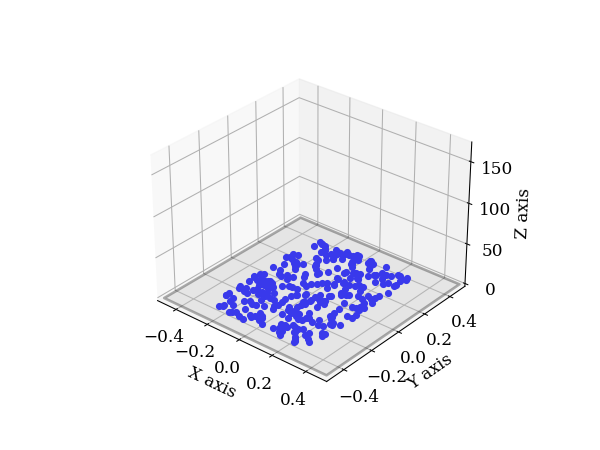

In [6]:
field.plot_scene(vsam_size=1)

## Avaliando o que medimos

Note que a pressão sonora medida tem dimensão $M \times N_f$, em que $N_f$ é o número de frequências simuladas. 

In [7]:
print(controls.freq)
print(receivers.coord.shape)
print(field.pres_s[0].shape)

[ 800 1000 1500 2000]
(290, 3)
(290, 4)


# Decomposição em ondas planas (Quais são os passos?)

1. Você possui $M$ medições nas coordenadas $\textbf{r}_1, \cdots, \textbf{r}_M$;

2. Você deve criar uma série de direções possíveis para as ondas planas (aqui - direções distribuídas numa esfera unitária). A esfera será composta de $L$ ondas planas **propagantes**. O vetor unitário associado à direção de propagação será multiplicado por $k_0$, de forma que você tenha vetores número de onda  $\textbf{k}_1, \cdots, \textbf{k}_L$;

3. Criar a matriz do problema:

\begin{equation}
\textbf{H} =
\begin{bmatrix}
\mathrm{e}^{-\mathrm{j}\textbf{k}_1\cdot \textbf{r}_1} & \mathrm{e}^{-\mathrm{j}\textbf{k}_2\cdot \textbf{r}_1} & \ldots & \mathrm{e}^{-\mathrm{j}\textbf{k}_{L}\cdot \textbf{r}_1}\\
\mathrm{e}^{-\mathrm{j}\textbf{k}_1\cdot \textbf{r}_2} & \mathrm{e}^{-\mathrm{j}\textbf{k}_2\cdot \textbf{r}_2} & \ldots & \mathrm{e}^{-\mathrm{j}\textbf{k}_{L}\cdot \textbf{r}_2}\\
\vdots & \vdots & \ddots & \vdots \\
\mathrm{e}^{-\mathrm{j}\textbf{k}_1\cdot \textbf{r}_M} & \mathrm{e}^{-\mathrm{j}\textbf{k}_2\cdot \textbf{r}_M} & \ldots & \mathrm{e}^{-\mathrm{j}\textbf{k}_{L}\cdot \textbf{r}_M}
\end{bmatrix}
\end{equation}

4. Computar o SVD da matriz $\textbf{H} = \textbf{U}\Sigma\textbf{V}^T$
5. Usar o SVD e o vetor $\textbf{p}$ para computar um parâmetro de regularização, $\lambda$.
6. Computar a solução regularizada

\begin{equation}
\hat{\textbf{x}}_{\lambda} = \sum\limits_{i=1}^{L}\varphi_{i}^{[\lambda]}\frac{\textbf{u}_{i}^{T}\textbf{b}}{\sigma_i} \textbf{v}_{i}
\end{equation}

7. Reconstrução e análise

# Montando o problema do zero (para uma frequência)

In [36]:
index = 1
freq = controls.freq[index]
print(r'freq = {0:.2f} Hz'.format(freq))
# Receptores
r_vecs = receivers.coord
print('shape da matriz de receptores: {}'.format(r_vecs.shape))
# Dados medidos (com algum ruído)
p = field.pres_s[0][:, index]
print('shape da matriz p: {}'.format(p.shape))

freq = 1000.00 Hz
shape da matriz de receptores: (290, 3)
shape da matriz p: (290,)


You choose L-curve to find optimal regularization parameter
The number of created waves is: 642


<IPython.core.display.Javascript object>


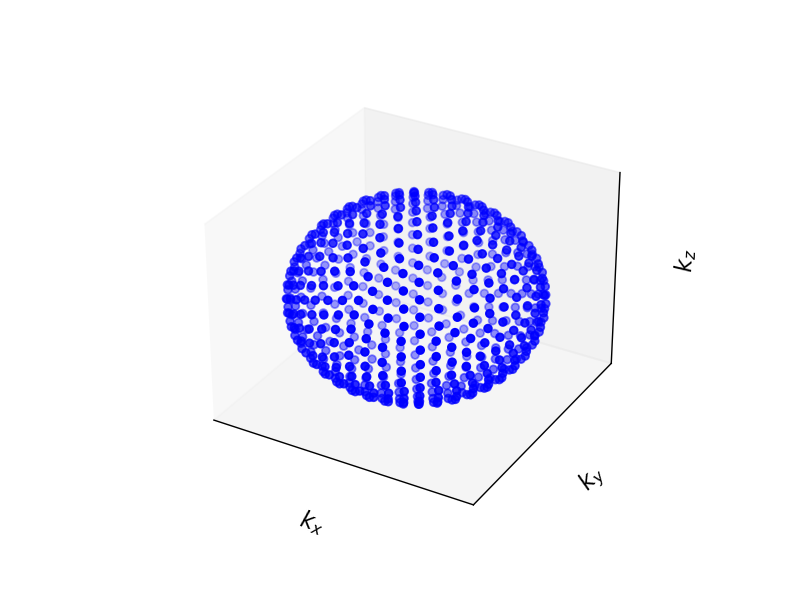

In [37]:
# Direções das ondas propagantes
ff_ded = Decomposition()
ff_ded.wavenum_dir(n_waves = 600, plot = True)
dirs = ff_ded.dir

In [38]:
idk = 25
print(dirs[idk,:])
print(np.linalg.norm(dirs[idk,:]))

[-0.9162442  0.3012589 -0.2640828]
1.0


In [39]:
# vetores k
k0 = controls.k0[index]
print(r'k_0 = {0:.2f}'.format(k0))
k_vec = k0 * dirs
# Matriz H
H = np.exp(-1j*r_vecs @ k_vec.T)
print('shape da matriz H: {}'.format(H.shape))

k_0 = 18.32
shape da matriz H: (290, 642)


In [40]:
idk = 25
print(k_vec[idk,:])
print(np.linalg.norm(k_vec[idk,:]))

[-16.78406     5.5185585  -4.8375545]
18.318327


shape da matriz U: (290, 290)
shape da matriz Sigma: (290,)
shape da matriz V^T: (290, 642)


<IPython.core.display.Javascript object>


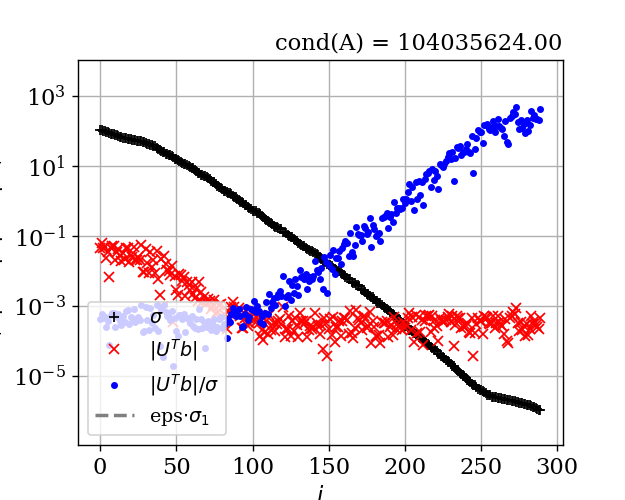

<IPython.core.display.Javascript object>


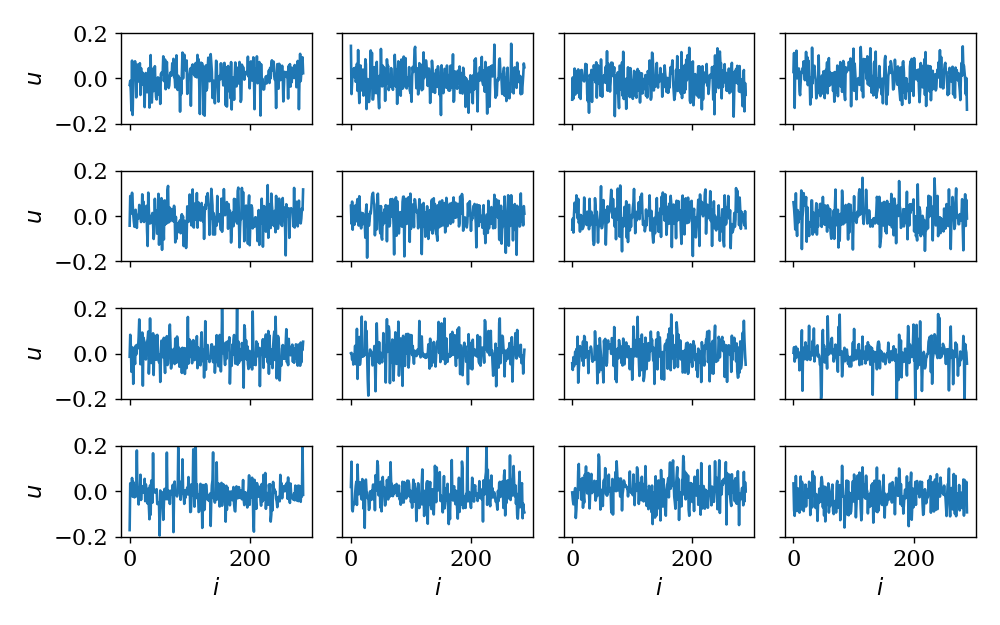

In [41]:
# SVD
[U,s,V] = lc.csvd(H)
print('shape da matriz U: {}'.format(U.shape))
print(r'shape da matriz Sigma: {}'.format(s.shape))
print(r'shape da matriz V^T: {}'.format(V.T.shape))
# plot Picard
lc.plot_picard(U,s,p)
# plot column vectors
lc.plot_colvecs(np.real(U))

# GCV

Compute o parâmetro de regularização por GCV e então a solução de Tikhonov

<IPython.core.display.Javascript object>


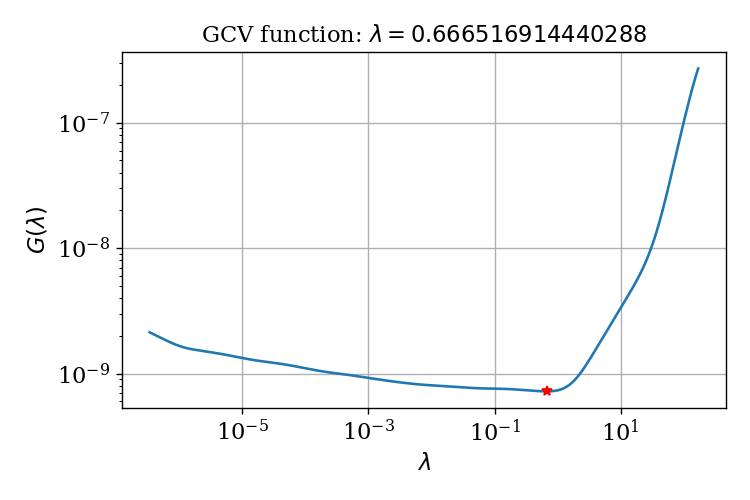

In [24]:
lam_gcv = lc.gcv_lambda(U, s, p, print_gcvfun = True)
x_gcv = lc.tikhonov(U, s, V, p, lam_gcv)

# L-curve

Compute o parâmetro de regularização por L-curve e então a solução de Tikhonov

C:\Users\Cliente\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


<IPython.core.display.Javascript object>


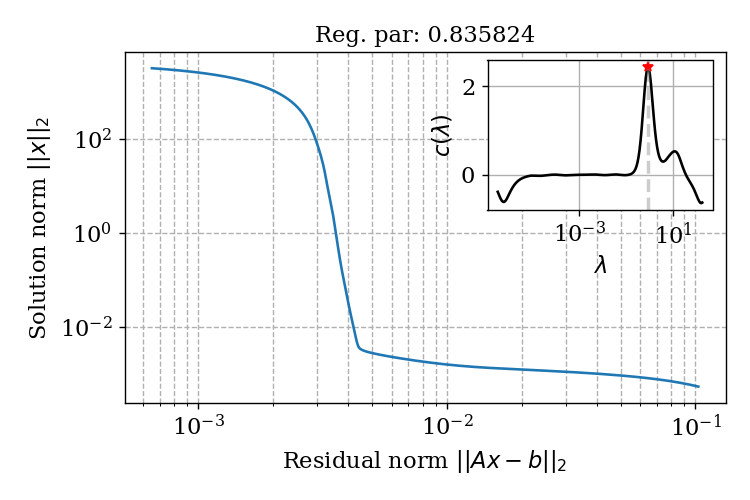

In [25]:
lam_lc = lc.l_curve(U, s, p, plotit = True)
x_lc = lc.tikhonov(U, s, V, p, lam_lc[0])

# Plot a result

<IPython.core.display.Javascript object>


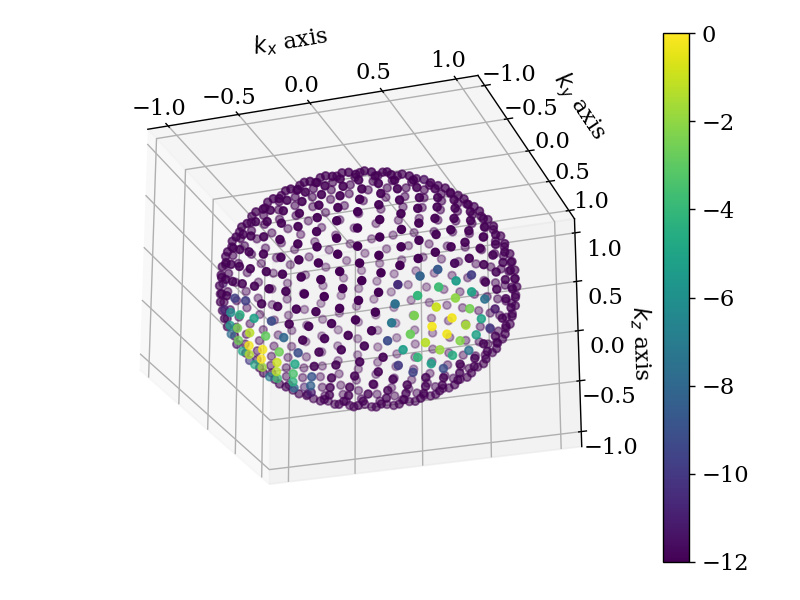

Norm of difference L-curve vs. GCV: 0.0002474529792089685


In [26]:
dinrange = 12
sol = x_lc
color_par = 20*np.log10(np.abs(sol)/np.amax(np.abs(sol)))
id_outofrange = np.where(color_par < -dinrange)
color_par[id_outofrange] = -dinrange
vmin = -dinrange
vmax = 0

fig = plt.figure()
ax = plt.axes(projection ="3d")
pp=ax.scatter(dirs[:,0], dirs[:,1], dirs[:,2], c = color_par, vmin = vmin, vmax = vmax)
fig.colorbar(pp)
ax.set_xlabel(r'$k_x$ axis')
ax.set_ylabel(r'$k_y$ axis')
ax.set_zlabel(r'$k_z$ axis')
plt.tight_layout()

print('Norm of difference L-curve vs. GCV: {}'.format(np.linalg.norm(x_lc-x_gcv)))

# Going pro

O que quero dizer com isso é que você pode programar tudo de forma organizada e ter escolhas como o tipo de regularização, escolha automática do parâmetro de regularização, plots das informações, reconstrução, etc. Assim, tudo fica organizado e você consegue fazer as coisas com boa repetibilidade. 

You choose GCV to find optimal regularization parameter
The number of created waves is: 2562


<IPython.core.display.Javascript object>


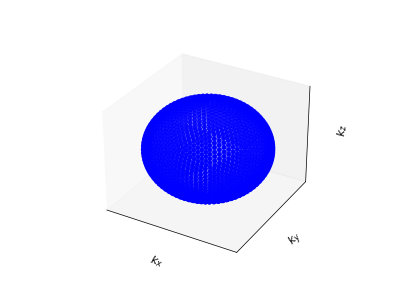

In [6]:
dec_gcv = Decomposition(field.pres_s[0], controls = controls, receivers=receivers, regu_par = 'GCV')
dec_gcv.wavenum_dir(n_waves = 2542, plot = True)


Calculating Tikhonov inversion...:   0%|          | 0/4 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


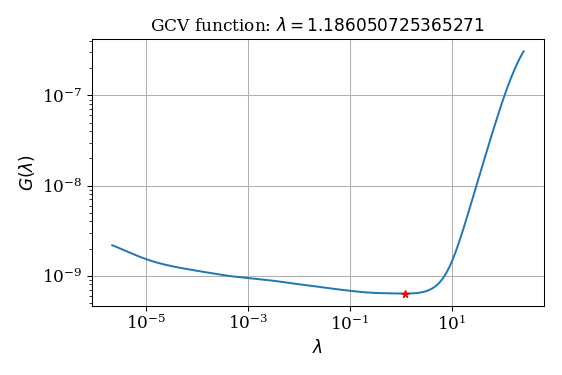


Calculating Tikhonov inversion...:  25%|██▌       | 1/4 [00:00<00:01,  2.58it/s]

<IPython.core.display.Javascript object>


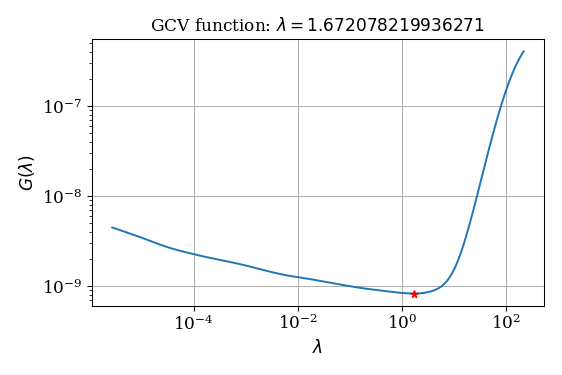


Calculating Tikhonov inversion...:  50%|█████     | 2/4 [00:00<00:00,  2.48it/s]

<IPython.core.display.Javascript object>


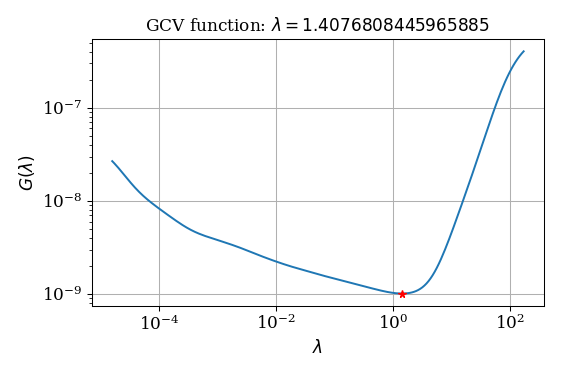


Calculating Tikhonov inversion...:  75%|███████▌  | 3/4 [00:01<00:00,  2.48it/s]

<IPython.core.display.Javascript object>


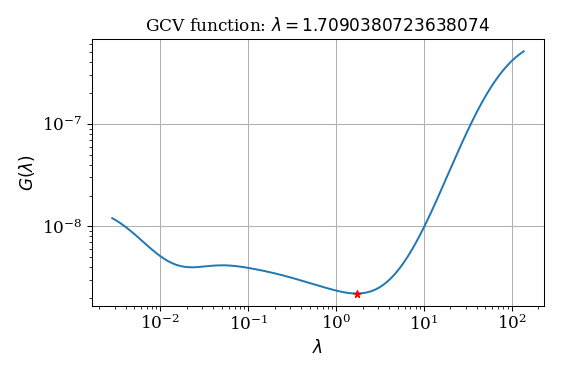


Calculating Tikhonov inversion...: 100%|██████████| 4/4 [00:01<00:00,  2.38it/s]

Interpolating the grid for P(k): 100%|██████████| 4/4 [00:00<00:00, 23.59it/s]


In [11]:
dec_gcv.pk_tikhonov(plot_l = True, method = 'Tikhonov')
dec_gcv.pk_interpolate()

<IPython.core.display.Javascript object>


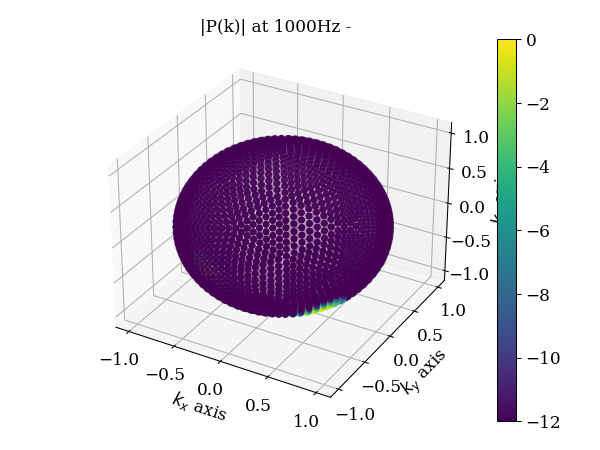

In [12]:
freq_view = 1000
dec_gcv.plot_pk_sphere(freq=freq_view, db=True, dinrange=12, travel=False)

<IPython.core.display.Javascript object>


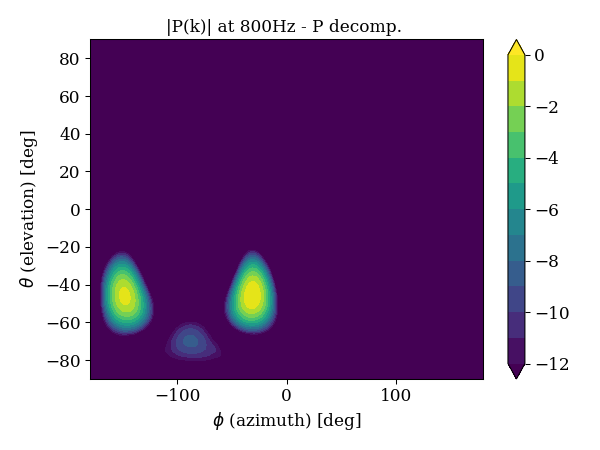

<IPython.core.display.Javascript object>


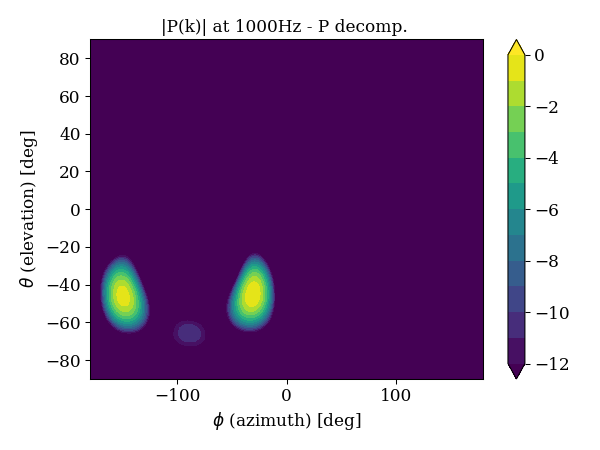

<IPython.core.display.Javascript object>


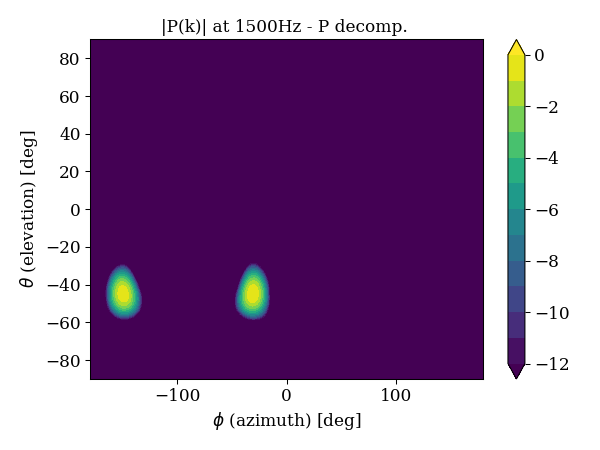

<IPython.core.display.Javascript object>


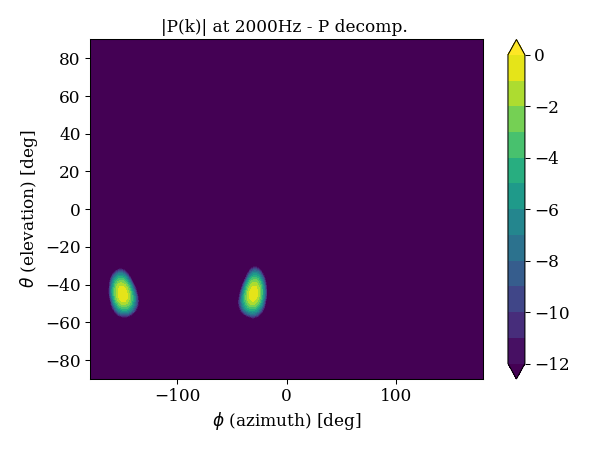

In [13]:
dinrange = 12
dec_gcv.plot_pk_map(freq=800, db=True, dinrange=dinrange)
dec_gcv.plot_pk_map(freq=1000, db=True, dinrange=dinrange)
dec_gcv.plot_pk_map(freq=1500, db=True, dinrange=dinrange)
dec_gcv.plot_pk_map(freq=2000, db=True, dinrange=dinrange)

# Reconstrução

In [14]:
xy_limits = 0.4
n_pts = 20
xcoord = np.linspace(-xy_limits, xy_limits, n_pts)
ycoord = np.linspace(-xy_limits, xy_limits, n_pts)
x_grid, y_grid = np.meshgrid(xcoord, ycoord)

In [15]:
rec_coords = np.zeros((len(x_grid.flatten()),3))
rec_coords[:,0] = x_grid.flatten()
rec_coords[:,1] = y_grid.flatten()
rec_coords[:,2] = 0.1 + np.zeros(len(x_grid.flatten()))

In [16]:
index = 0
# onde reconstruir
rec_recon = Receiver()
rec_recon.coord = rec_coords

# Reconstrução
dec_gcv.reconstruct_pu(rec_recon)
dec_gcv.p_recon.shape


Reconstructing sound field...: 100%|██████████| 4/4 [00:00<00:00, 10.13it/s]


(400, 4)

In [17]:
p_reshaped = np.reshape(dec_gcv.p_recon[:,index], x_grid.shape)
# Referencia
field_recon = FreeField(air, controls, rec_recon)
field_recon.monopole_ff(sources = source)
field_recon.pres_s[0] += field_recon.pres_s[1]
#p_ref_reshaped = np.reshape(field_recon.pres_s[0][:,1]/np.amax(np.abs(field_recon.pres_s[0][:,1])), x_grid.shape)
p_ref_reshaped = np.reshape(field_recon.pres_s[0][:,index], x_grid.shape)

NMSE = 0.0025336742227941517


<IPython.core.display.Javascript object>


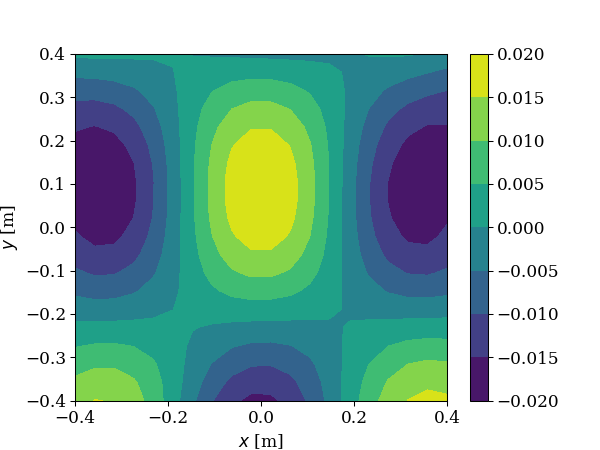

<IPython.core.display.Javascript object>


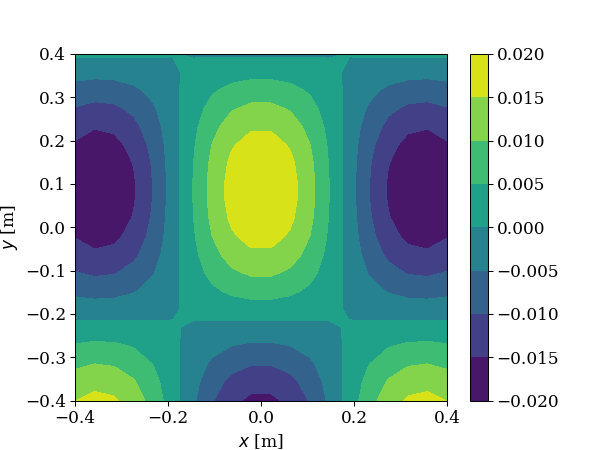

Text(0, 0.5, '$y$ [m]')

In [18]:
print('NMSE = {}'.format(lc.nmse(dec_gcv.p_recon[:,index], field_recon.pres_s[0][:,index])))

fig = plt.figure()
pp=plt.contourf(x_grid, y_grid, np.real(p_reshaped))
fig.colorbar(pp)
plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$y$ [m]')

fig = plt.figure()
pp=plt.contourf(x_grid, y_grid, np.real(p_ref_reshaped))
fig.colorbar(pp)
plt.xlabel(r'$x$ [m]')
plt.ylabel(r'$y$ [m]')

In [49]:
import scipy.io
file_path = 'ang_spk.mat'
scipy.io.savemat(file_path, {'r_vecs': r_vecs,
                             'dirs': dirs,                            
                            'freq': controls.freq,
                             'k0' : controls.k0,
                            'p': p,
                            'Upy' : U,
                            'spy' : s,
                            'Vpy' : V,
                            'Hpy' : H})